In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Chapter 11 - Ignis

In [2]:
# Import plot and math libraries
import numpy as np
import matplotlib.pyplot as plt

# Import the noise models and some standard error methods
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import amplitude_damping_error, phase_damping_error

# Import all three coherence circuits generators and fitters 
from qiskit.ignis.characterization.coherence import t1_circuits, t2_circuits, t2star_circuits
from qiskit.ignis.characterization.coherence import T1Fitter, T2Fitter, T2StarFitter


In [3]:
# Generate the T1 test circuits

# Generate a list of number of gates to add to each circuit
# using np.linspace so that the number of gates increases linearly 
# and append with a large span at the end of the list (200-4000)
num_of_gates = np.append((np.linspace(1, 100, 12)).astype(int), np.array([200, 400, 800, 1000, 2000, 4000]))

#Define the gate time for each Identity gate
gate_time = 0.1

# Select the first qubit as the one we wish to measure T1
qubits = [0]

# Generate the test circuits given the above parameters
test_circuits, delay_times = t1_circuits(num_of_gates, gate_time, qubits)

# The number of I gates appended for each circuit
print('Number of gates per test circuit: \n', num_of_gates, '\n')

# The gate time of each circuit (number of I gates * gate_time)
print('Delay times for each test circuit created, respectively:\n', delay_times)


Number of gates per test circuit: 
 [   1   10   19   28   37   46   55   64   73   82   91  100  200  400
  800 1000 2000 4000] 

Delay times for each test circuit created, respectively:
 [1.0e-01 1.0e+00 1.9e+00 2.8e+00 3.7e+00 4.6e+00 5.5e+00 6.4e+00 7.3e+00
 8.2e+00 9.1e+00 1.0e+01 2.0e+01 4.0e+01 8.0e+01 1.0e+02 2.0e+02 4.0e+02]


Total test circuits created:  18
Test circuit 1 with 1 Identity gate:


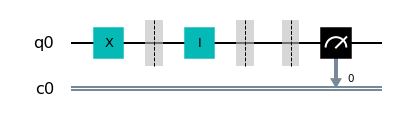

In [4]:
print('Total test circuits created: ', len(test_circuits))
print('Test circuit 1 with 1 Identity gate:')
test_circuits[0].draw()


Test circuit 2 with 10 Identity gates:


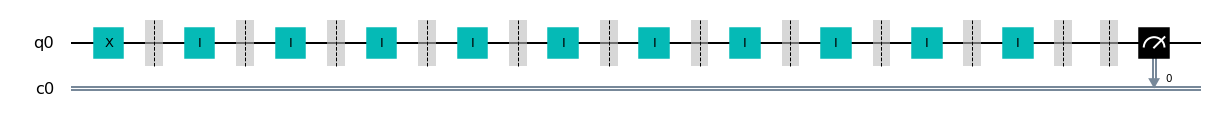

In [5]:
print('Test circuit 2 with 10 Identity gates:')
test_circuits[1].draw()


In [6]:
# Set the simulator with amplitude damping noise

# Set the amplitude damping noise channel parameters T1 and Lambda
t1 = 20
lam = np.exp(-gate_time/t1)

# Generate the amplitude dampling error channel
error = amplitude_damping_error(1 - lam)
noise_model = NoiseModel()

# Set the dampling error to the ID gate on qubit 0.
noise_model.add_quantum_error(error, 'id', [0])


In [7]:
# Run the simulator with the generated noise model
backend = Aer.get_backend('qasm_simulator')
shots = 200
backend_result = execute(test_circuits, backend, shots=shots, noise_model=noise_model).result()


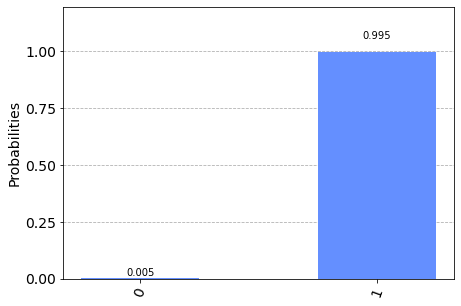

In [8]:
# Plot the noisy results of the largest (last in the list) circuit
plot_histogram(backend_result.get_counts(test_circuits[0]))


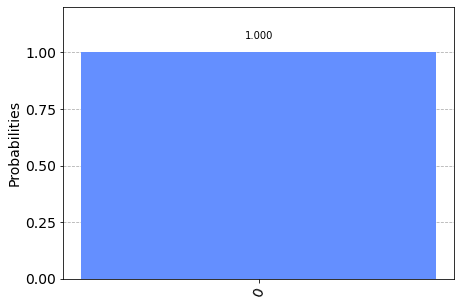

In [9]:
# Plot the noisy results of the largest (last in the list) circuit
plot_histogram(backend_result.get_counts(test_circuits[len(test_circuits)-1]))


In [10]:
# Initialize the parameters for the T1Fitter, A, T1, and B
param_t1 = t1*1.2
param_a = 1.0
param_b = 0.0


<AxesSubplot:title={'center':'$T_1$ for qubit 0'}, xlabel='Time [micro-seconds]', ylabel='Excited State Population'>

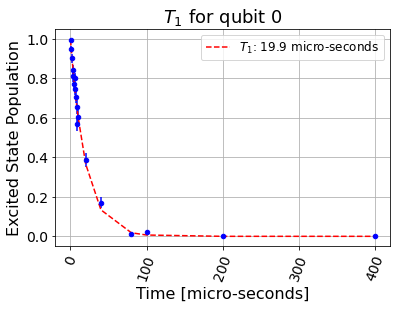

In [11]:
# Generate the T1Fitter for our test circuit results
fit = T1Fitter(backend_result, delay_times, qubits,
               fit_p0=[param_a, param_t1, param_b],
               fit_bounds=([0, 0, -1], [2, param_t1*2, 1]))

# Plot the fitter results for T1 over each test circuit's delay time
fit.plot(0)


In [12]:
# Import the thermal relaxation error we will use to create our error
from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error

# Import the T2Fitter Class and t2_circuits method
from qiskit.ignis.characterization.coherence import T2Fitter
from qiskit.ignis.characterization.coherence import t2_circuits


In [13]:
num_of_gates = (np.linspace(1, 300, 50)).astype(int)
gate_time = 0.1

# Note that it is possible to measure several qubits in parallel
qubits = [0]

t2echo_test_circuits, t2echo_delay_times = t2_circuits(num_of_gates, gate_time, qubits)

# The number of I gates appended for each circuit
print('Number of gates per test circuit: \n', num_of_gates, '\n')

# The gate time of each circuit (number of I gates * gate_time)
print('Delay times for T2 echo test circuits:\n', t2echo_delay_times)


Number of gates per test circuit: 
 [  1   7  13  19  25  31  37  43  49  55  62  68  74  80  86  92  98 104
 110 116 123 129 135 141 147 153 159 165 171 177 184 190 196 202 208 214
 220 226 232 238 245 251 257 263 269 275 281 287 293 300] 

Delay times for T2 echo test circuits:
 [ 0.2  1.4  2.6  3.8  5.   6.2  7.4  8.6  9.8 11.  12.4 13.6 14.8 16.
 17.2 18.4 19.6 20.8 22.  23.2 24.6 25.8 27.  28.2 29.4 30.6 31.8 33.
 34.2 35.4 36.8 38.  39.2 40.4 41.6 42.8 44.  45.2 46.4 47.6 49.  50.2
 51.4 52.6 53.8 55.  56.2 57.4 58.6 60. ]


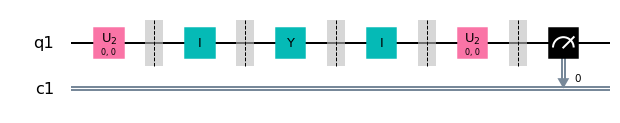

In [14]:
# Draw the first T2 test circuit
t2echo_test_circuits[0].draw()


In [15]:
# We'll create a noise model on the backend simulator
backend = Aer.get_backend('qasm_simulator')
shots = 400

# set the t2 decay time
t2 = 25.0

# Define the T2 noise model based on the thermal relaxation error model
t2_noise_model = NoiseModel()
t2_noise_model.add_quantum_error(thermal_relaxation_error(np.inf, t2, gate_time, 0.5), 'id', [0])

# Execute the circuit on the noisy backend
t2echo_backend_result = execute(t2echo_test_circuits, backend, shots=shots,
                                       noise_model=t2_noise_model, optimization_level=0).result()


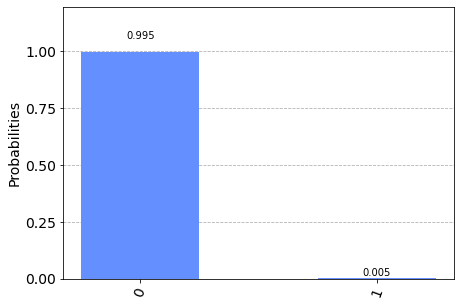

In [16]:
plot_histogram(t2echo_backend_result.get_counts(t2echo_test_circuits[0])) 

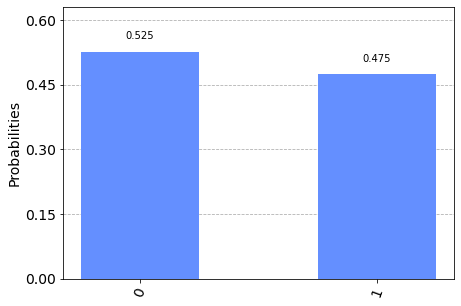

In [17]:
plot_histogram(t2echo_backend_result.get_counts(t2echo_test_circuits[len(t2echo_test_circuits)-1]))

# T2 Decoherence Time

{'0': [array([ 0.52316965, 28.330302  ,  0.47513291])]}


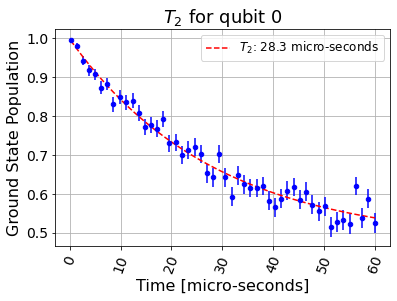

In [18]:
# Generate the T2Fitter class using similar parameters as the T1Fitter
t2echo_fit = T2Fitter(t2echo_backend_result, t2echo_delay_times, 
qubits, fit_p0=[0.5, t2, 0.5], fit_bounds=([-0.5, 0, -0.5], [1.5, 40, 1.5]))

# Print and plot the results
print(t2echo_fit.params)  
t2echo_fit.plot(0)
plt.show()


In [19]:
# 50 total linearly spaced number of gates 
# 30 from 10->150, 20 from 160->450
num_of_gates = np.append((np.linspace(1, 150, 30)).astype(int), (np.linspace(160,450,20)).astype(int))

# Set the Identity gate delay time
gate_time = 0.1

# Select the qubit to measure T2*
qubits = [0]

# Generate the 50 test circuits with number of oscillations set to 4
test_circuits, delay_times, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=4)
print('Circuits generated: ', len(test_circuits))
print('Delay times: ', delay_times)
print('Oscillating frequency: ', osc_freq)


Circuits generated:  50
Delay times:  [ 0.1  0.6  1.1  1.6  2.1  2.6  3.1  3.6  4.2  4.7  5.2  5.7  6.2  6.7
  7.2  7.8  8.3  8.8  9.3  9.8 10.3 10.8 11.4 11.9 12.4 12.9 13.4 13.9
 14.4 15.  16.  17.5 19.  20.5 22.1 23.6 25.1 26.6 28.2 29.7 31.2 32.7
 34.3 35.8 37.3 38.8 40.4 41.9 43.4 45. ]
Oscillating frequency:  0.08888888888888889


OrderedDict([('barrier', 3), ('h', 2), ('id', 1), ('u1', 1), ('measure', 1)])


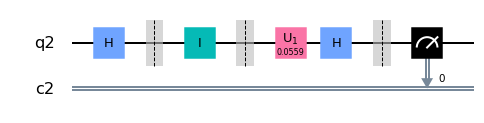

In [20]:
print(test_circuits[0].count_ops())
test_circuits[0].draw()


OrderedDict([('barrier', 8), ('id', 6), ('h', 2), ('u1', 1), ('measure', 1)])


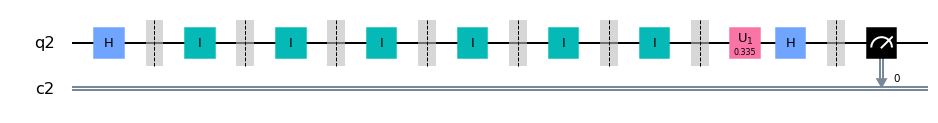

In [21]:
print(test_circuits[1].count_ops())
test_circuits[1].draw()


In [22]:
# Get the backend to execute the test circuits 
backend = Aer.get_backend('qasm_simulator')

# Set the T2* value to 10
t2Star = 10

# Set the phase damping error and add it to the noise model to the Identity gates
error = phase_damping_error(1 - np.exp(-2*gate_time/t2Star))
noise_model = NoiseModel()
noise_model.add_quantum_error(error, 'id', [0])

# Run the simulator
shots = 1024
backend_result = execute(test_circuits, backend, shots=shots, 
noise_model=noise_model).result()


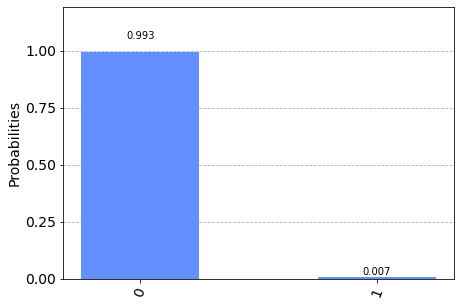

In [23]:
# Plot the noisy results of the shortest (first in the list) circuit
plot_histogram(backend_result.get_counts(test_circuits[0]))


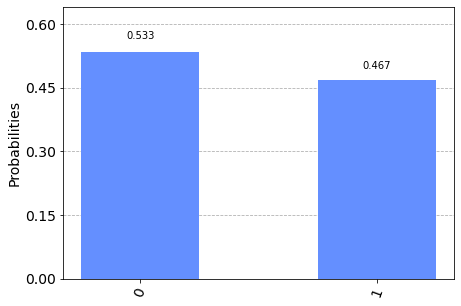

In [24]:
# Plot the noisy results of the largest (last in the list) circuit
plot_histogram(backend_result.get_counts(test_circuits[len(test_circuits)-1]))


<AxesSubplot:title={'center':'$T_2^*$ for qubit 0'}, xlabel='Time [micro-seconds]', ylabel='Ground State Population'>

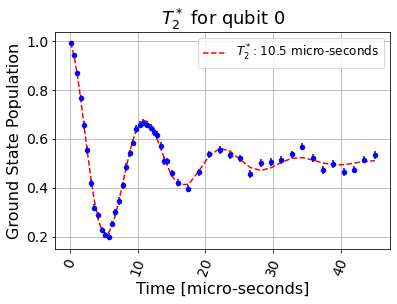

In [25]:
# Set the initial values of the T2StarFitter parameters
param_T2Star = t2Star*1.1
param_A = 0.5
param_B = 0.5

# Generate the T2StarFitter with the given parameters and bounds
fit = T2StarFitter(backend_result, delay_times, qubits,
                          fit_p0=[0.5, t2Star, osc_freq, 0, 0.5],
                          fit_bounds=([-0.5, 0, 0, -np.pi, -0.5],
                                      [1.5, 40, 2*osc_freq, np.pi, 1.5]))

# Plot the qubit characterization from the T2StarFitter
fit.plot(0)


# Mitigating Readout errors

In [26]:
# Import Qiskit classes
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


32


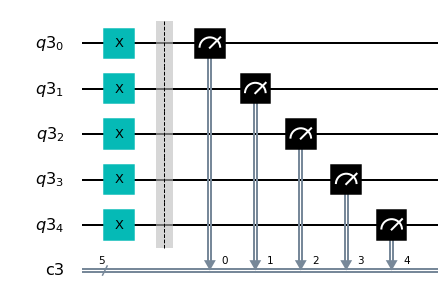

In [27]:
# Generate the calibration circuits
# Set the number of qubits
num_qubits = 5
# Set the qubit list to generate the measurement calibration circuits
qubit_list = [0,1,2,3,4]

# Generate the measurement calibrations circuits and state labels
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=num_qubits, circlabel='mcal')
# Print the number of measurement calibration circuits generated
print(len(meas_calibs))
# Draw any of the generated calibration circuits, 0-31. 
# In this example we will draw the last one.
meas_calibs[31].draw()


In [28]:
state_labels

['00000',
 '00001',
 '00010',
 '00011',
 '00100',
 '00101',
 '00110',
 '00111',
 '01000',
 '01001',
 '01010',
 '01011',
 '01100',
 '01101',
 '01110',
 '01111',
 '10000',
 '10001',
 '10010',
 '10011',
 '10100',
 '10101',
 '10110',
 '10111',
 '11000',
 '11001',
 '11010',
 '11011',
 '11100',
 '11101',
 '11110',
 '11111']

In [29]:
# Execute the calibration circuits without noise on the qasm simulator
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)

# Obtain the measurement calibration results
cal_results = job.result()

# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


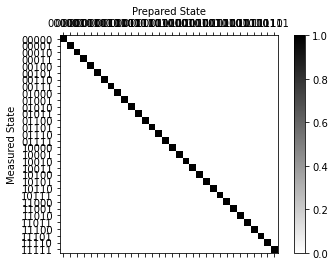

In [30]:
meas_fitter.plot_calibration()

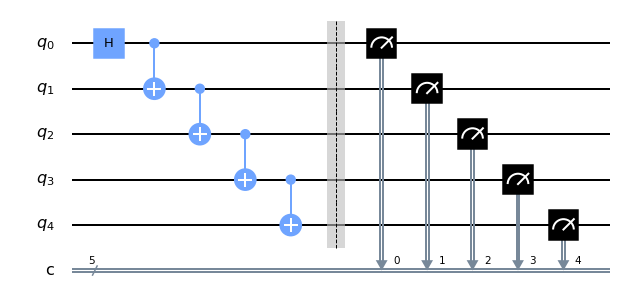

In [31]:
# Create a 5 qubit circuit
qc = QuantumCircuit(5,5)
# Place the first qubit in superpostion
qc.h(0)
# Entangle all other qubits together
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)
# Include a barrier just to ease visualization of the circuit
qc.barrier()
# Measure and draw the final circuit
qc.measure([0,1,2,3,4], [0,1,2,3,4])
qc.draw()


In [32]:
# Obtain the least busy backend device, not a simulator
from qiskit.providers.ibmq import least_busy
# Find the least busy operational quantum device with 5 or more qubits
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and not x.configuration().simulator and x.status().operational==True))
# Print the least busy backend
print("least busy backend: ", backend)


least busy backend:  ibmq_ourense


In [33]:
# Execute the quantum circuit on the backend
job = execute(qc, backend=backend, shots=1024)
results = job.result()


In [35]:
# Results from backend without mitigating the noise
noisy_counts = results.get_counts()

# Obtain the measurement fitter object
measurement_filter = meas_fitter.filter

# Mitigate the results by applying the measurement fitter
filtered_results = measurement_filter.apply(results)

# Get the mitigated result counts
filtered_counts = filtered_results.get_counts(0)


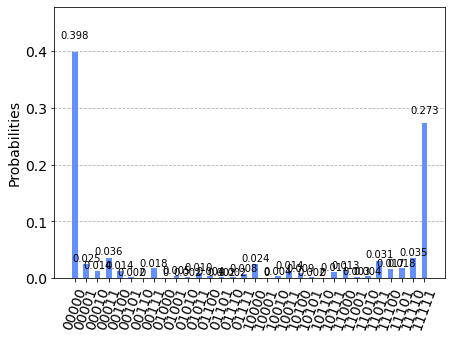

In [36]:
plot_histogram(noisy_counts)

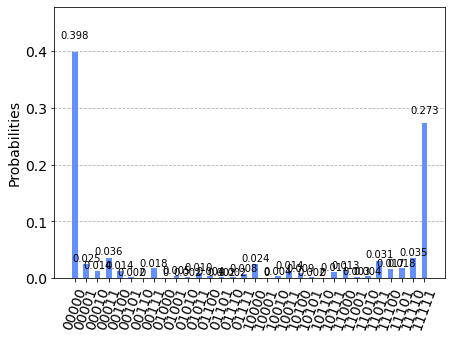

In [37]:
plot_histogram(filtered_counts)

In [38]:
import qiskit.tools.jupyter
%qiskit_version_table